
# Air Bnb New User Bookings 
**Predict user country destination**

=========================================================
# Important Notes
* countries.csv: summary statistics of destination countries in this dataset and their locations
* age_gender_bkts.csv: summary statistics of users' age group, gender, country of destination
* **'NDF'** --> no booking
* **country_destination** is our predection target it is not avalible at test dataset.

**Submission File:**
For every user in the dataset, submission files should contain two columns: id and country. The destination country predictions must be ordered such that the most probable destination country goes first.

**Evaluation:**
For each new user, you are to make a maximum of 5 predictions on the country of the first booking. The ground truth country is marked with relevance = 1, while the rest have relevance = 0.

For example, if for a particular user the destination is FR, then the predictions become

=========================================================

**Data Cleansing & Preparation Summery**

* Gender: convert all "unknown" values into nan 
* Filter age between 1-100 and set to others to NAN**
* First_browser: convert all "unknown" values into nan
* date_account_created: convert to datetime format
* timestamp_first_active: convert to datetime format

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#add colores for plot bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']        

/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip


# Load data

In [2]:
# convert date columns into datetime format while loading
train_df = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip', parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])

test_df= pd.read_csv('../input/airbnb-recruiting-new-user-bookings/test_users.csv.zip',parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])

bookings_data  = pd.read_csv("/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip")

# Combining test and train datasets

for this compitition If this is not done, the number of dummy variable columns do not match in test and train data. Some items present in train data and are not present in test data like browser type. 

i got many errors like: **ValueError: X has 122 features per sample; expecting 155**

In [3]:
train_test_combin = pd.concat((train_df, test_df), axis = 0, ignore_index = True)

# Exploratory Data Analysis (EDA)

In [4]:
train_test_combin.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
train_test_combin.shape

(275547, 16)

In [6]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [7]:
train_df.shape

(213451, 16)

In [8]:
test_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,2014-07-01 00:00:06,NaT,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,2014-07-01 00:00:51,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,2014-07-01 00:01:48,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,2014-07-01 00:02:15,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,2014-07-01 00:03:05,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [9]:
test_df.shape

(62096, 15)

**check for Null values**

In [10]:
train_test_combin.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         186639
gender                          0
age                        116866
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
country_destination         62096
dtype: int64

# Data Visulization

**Min / Max Date in our data**

The data is 5 years data starting from 2010 up to 2014

In [11]:
print(train_test_combin.date_account_created.min())
print(train_test_combin.date_account_created.max())

2010-01-01 00:00:00
2014-09-30 00:00:00


**Signup method used by users**

In [12]:
train_test_combin['signup_method'].value_counts()

basic       198222
facebook     74864
google        2438
weibo           23
Name: signup_method, dtype: int64

<AxesSubplot:>

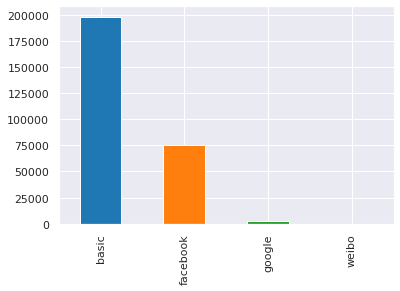

In [13]:
train_test_combin.signup_method.value_counts(dropna=False).plot(kind='bar', color=colors)

**Users Devices**

In [14]:
train_test_combin['first_device_type'].value_counts()

Mac Desktop           106328
Windows Desktop        86948
iPhone                 39814
iPad                   18036
Other/Unknown          11167
Android Phone           9458
Android Tablet          2098
Desktop (Other)         1507
SmartPhone (Other)       191
Name: first_device_type, dtype: int64

<AxesSubplot:>

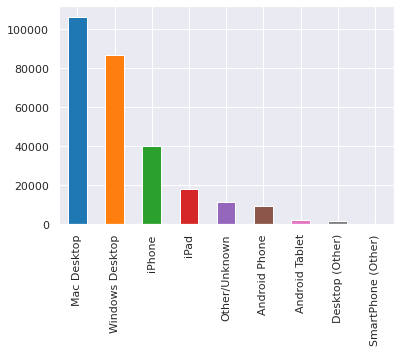

In [15]:
train_test_combin.first_device_type.value_counts(dropna=False).plot(kind='bar', color=colors)


**detailed view with % percent**

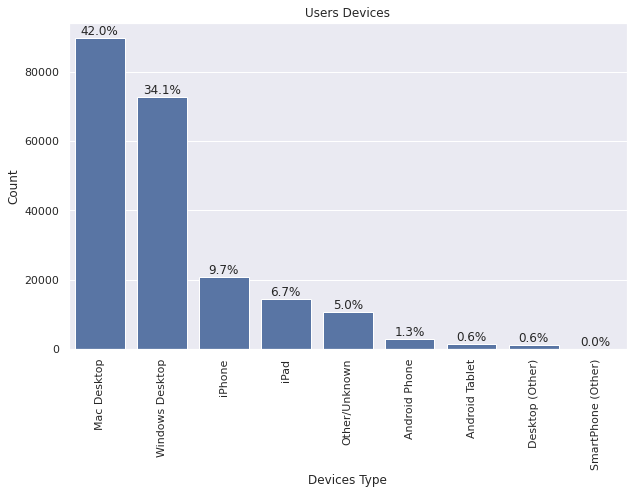

In [16]:
plt.figure(figsize=(10,6))
cd_count_idx = bookings_data['first_device_type'].value_counts().index
sns.countplot(data = bookings_data, x = 'first_device_type', order = cd_count_idx, color = sns.color_palette()[0])
plt.xlabel('Devices Type')
plt.ylabel('Count')
plt.title('Users Devices')
plt.xticks(rotation=90)
cd_count_val = bookings_data['first_device_type'].value_counts()

for i in range(cd_count_val.shape[0]):
    count = cd_count_val[i]
    percentage ='{:0.1f}%'.format(100 * count / len(bookings_data))
    plt.text(i, count+1000, percentage, ha='center')

**Internet browsers used**

In [17]:
train_test_combin['first_browser'].value_counts()

Chrome                  78671
Safari                  53302
-unknown-               44394
Firefox                 38665
Mobile Safari           29636
IE                      24744
Chrome Mobile            3186
Android Browser          1577
AOL Explorer              254
Opera                     228
Silk                      172
IE Mobile                 118
BlackBerry Browser         89
Chromium                   83
Mobile Firefox             64
Maxthon                    60
Apple Mail                 45
Sogou Explorer             43
SiteKiosk                  27
Iron                       24
RockMelt                   24
IceWeasel                  14
Yandex.Browser             14
Pale Moon                  13
SeaMonkey                  12
CometBird                  12
Camino                      9
TenFourFox                  8
Opera Mini                  8
wOSBrowser                  7
CoolNovo                    6
Avant Browser               4
Opera Mobile                4
Mozilla   

> Google Chrome is the most poular Internet exolorer 

**Top 10 browsers**

<AxesSubplot:>

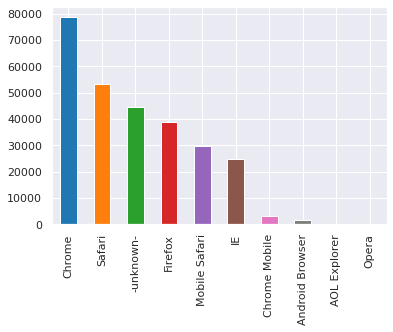

In [18]:
train_test_combin['first_browser'].value_counts().head(10).plot(kind='bar', color=colors)

**Gender and Age**
* Average age around 35.
* we have more females users than male

In [19]:
train_test_combin['gender'].value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

In [20]:
train_test_combin.groupby('gender').age.agg(['min','max','mean','count'])

,min,max,mean,count
gender,,,,
-unknown-,1.0,2014.0,44.581328,22237
FEMALE,1.0,2014.0,49.645347,71907
MALE,1.0,2014.0,45.191540,64258
OTHER,17.0,2014.0,57.146953,279


**Filter age between 1-100 and set others to NAN**

>  some of the age valus are not logical like(2014, 188...etc.)

In [21]:
train_test_combin.loc[train_test_combin.age > 100, 'age'] = np.nan

In [22]:
train_test_combin.groupby('gender').age.agg(['min','max','mean','count'])

,min,max,mean,count
gender,,,,
-unknown-,1.0,100.0,36.470110,21412
FEMALE,1.0,100.0,35.711567,70838
MALE,1.0,100.0,36.269660,63465
OTHER,17.0,78.0,35.876812,276


<AxesSubplot:>

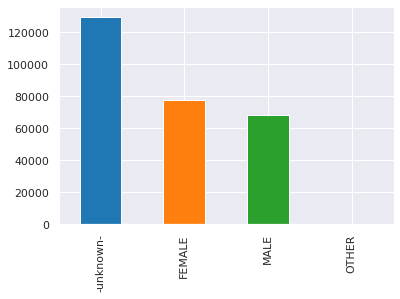

In [23]:
train_test_combin['gender'].value_counts().plot(kind='bar', color=colors)

**Gender % percent**

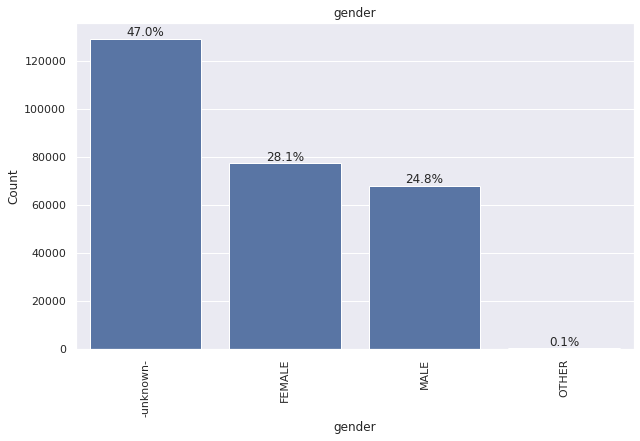

In [24]:
plt.figure(figsize=(10,6))
cd_count_idx = train_test_combin['gender'].value_counts().index
sns.countplot(data = train_test_combin, x = 'gender', order = cd_count_idx, color = sns.color_palette()[0])
plt.xlabel('gender')
plt.ylabel('Count')
plt.title('gender')
plt.xticks(rotation=90)

cd_count_val = train_test_combin['gender'].value_counts()

for i in range(cd_count_val.shape[0]):
    count = cd_count_val[i]
    percentage ='{:0.1f}%'.format(100 * count / len(train_test_combin))
    plt.text(i, count+1000, percentage, ha='center')

In [25]:
# Splitting date into Day-Month-Year
# account created
train_test_combin['dac_year'] = train_test_combin.date_account_created.dt.year
train_test_combin['dac_month'] = train_test_combin.date_account_created.dt.month
train_test_combin['dac_day'] = train_test_combin.date_account_created.dt.day

# Splitting date into Day-Month-Year
# time first active
train_test_combin['tfa_year'] = train_test_combin.timestamp_first_active.dt.year
train_test_combin['tfa_month'] = train_test_combin.timestamp_first_active.dt.month
train_test_combin['tfa_day'] = train_test_combin.timestamp_first_active.dt.day

<AxesSubplot:title={'center':'User Accounts Created Per Year'}>

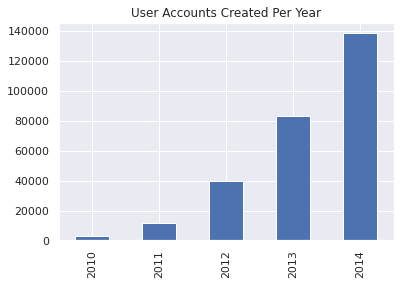

In [26]:
train_test_combin.dac_year.value_counts(sort=False).plot(kind='bar', title='User Accounts Created Per Year')

**Countries visited by Users**

<AxesSubplot:title={'center':'Countries Visited by Users'}>

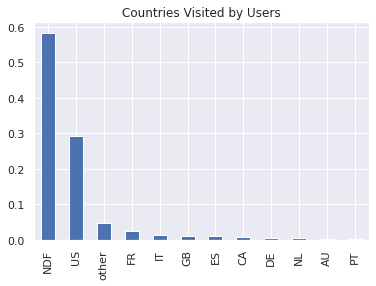

In [27]:
train_test_combin.country_destination.value_counts(normalize=True).plot(kind='bar',title='Countries Visited by Users')

> NDF: No data

> US is the main visisted country 

**Dropping uneanted columns**

* id: drop
* date_first_booking: drop
* date_account_created: drop
* timestamp_first_active: drop
* missing value: fill with 0
* gender replace -unknown- with NA

There is no impact on dropping all date columns since it is not used for the predetion 

In [28]:
X_train_data = train_df.drop(['id','date_account_created','date_first_booking','timestamp_first_active', 'country_destination'], axis=1)
X_test_data = test_df.drop(['id','date_account_created','date_first_booking','timestamp_first_active'], axis=1)
train_test_combin = train_test_combin.drop(['id', 'date_account_created','date_first_booking','timestamp_first_active','country_destination'], axis=1)


In [29]:
# Replace unknown with NAN to avoid error 
train_test_combin.gender.replace('-unknown-', np.nan, inplace=True)
train_test_combin.first_browser.replace('-unknown-', np.nan, inplace=True)

# Create Fetures 
convert all string values into numbers values using pandas get_dummies

In [30]:
# Create Fetures categorical columns 

features = ['gender', 'signup_method', 'signup_flow', 'language',
                'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app',
                'first_device_type', 'first_browser']

# Get Dummies Convert categorical variable into dummy/indicator variables.

train_test_combin = pd.get_dummies(train_test_combin,columns=features)

In [31]:
train_test_combin.head()

,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,gender_FEMALE,gender_MALE,gender_OTHER,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,NaN,2010,6,28,2009,3,19,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,2011,5,25,2009,5,23,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,56.0,2010,9,28,2009,6,9,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,42.0,2011,12,5,2009,10,31,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,41.0,2010,9,14,2009,12,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# xgboost

In [32]:
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [33]:
train_df_rows_no = train_df.shape[0]  

# Splitting the data into train and test again for the classifier
# rows number of train data will be used for splitting

# convert train_test_combin dataset into list
all_data_list = train_test_combin.values
X_train = all_data_list[:train_df_rows_no] #213451
X_test = all_data_list[train_df_rows_no:] # 213451

#Create labels
#labels = train_df['country_destination'].values
labler = LabelEncoder()
y = labler.fit_transform(train_df['country_destination'].values)

# Implementation of the classifier (decision tree)
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=22,
                    objective='multi:softprob', subsample=0.6, colsample_bytree=0.6, seed=0)               
xgb.fit(X_train, y)
y_pred = xgb.predict_proba(X_test) 


[13:08:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [34]:
#Taking the 5 classes with highest probabilities
# the requirements is to predict 5 predicts for each ID (user)
# so we will predict 5 times and save the result for each user 

test_ids = test_df['id']
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(test_ids)):
    idx = test_ids[i]
    ids += [idx] * 5
    #save 5 results for each user 
    cts += labler.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('submission.csv',index=False)

**Please consider upvoting if you find it useful to you !**

Thanks